In [39]:
import pandas as pd
import geopandas as gpd 
import numpy as np
import folium
from geopy.distance import great_circle
from geopy.geocoders import Nominatim
from shapely import Point, Polygon
import osmnx
from pyvrp import *
from pyvrp import plotting
import matplotlib.pyplot as plt
from pyvrp.stop import MaxRuntime
from folium.plugins import MeasureControl

In [40]:
# Getting Data with delivery points placements|Получение геоданных о расположении кафе
df = osmnx.geometries_from_place('Москва', tags = {'name':'Додо Пицца'}).reset_index()

C:\Users\cours\AppData\Local\Temp\ipykernel_2096\2317575949.py:2: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  df = osmnx.geometries_from_place('Москва', tags = {'name':'Додо Пицца'}).reset_index()


In [41]:
df.columns

Index(['element_type', 'osmid', 'amenity', 'brand', 'contact:email',
       'contact:facebook', 'contact:instagram', 'contact:phone', 'contact:vk',
       'contact:website', 'cuisine', 'delivery', 'diet:vegetarian', 'name',
       'name:en', 'name:ru', 'takeaway', 'geometry', 'brand:en', 'brand:ru',
       'brand:wikidata', 'brand:wikipedia', 'level', 'opening_hours',
       'opening_hours:url', 'addr:housenumber', 'addr:street',
       'internet_access', 'phone', 'website', 'is_in:neighbourhood', 'smoking',
       'wheelchair', 'check_date', 'contact:youtube', 'drive_through',
       'check_date:opening_hours', 'toilets', 'diet:vegan', 'air_conditioning',
       'diet:halal', 'diet:kosher', 'indoor_seating', 'outdoor_seating',
       'payment:credit_cards', 'payment:debit_cards', 'source',
       'check_date:diet:halal', 'check_date:diet:vegetarian',
       'check_date:smoking', 'payment:cash', 'addr:floor', 'website:menu',
       'internet_access:fee', 'coffee', 'operator:wikidata',


In [42]:
# Points of pizza delivery|ТОчки с доставкой пиццы
df[['element_type', 'osmid', 'amenity', 'brand', 'name', 'geometry', 'addr:street']].explore()

In [43]:
# Getting data with Moscow buildings| Получение координат московских зданий 
msk = gpd.read_file('buildings_levels.geojson')

<Axes: >

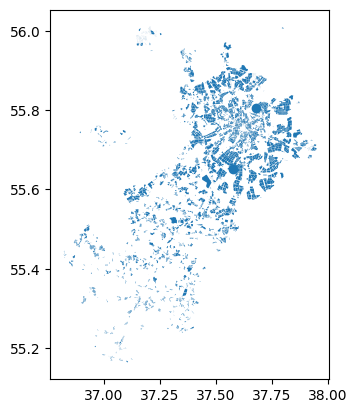

In [44]:
msk.plot()

## Problem to solve: we have some points with delivery and some points where the food needs to be delivered so we need to find optimal routes, number of couriers and? if needed vehicle types. We have also to observe a constration that food delivery works only for clients who are not further than 3km  from the delivery point

## Решается следующая задача: есть точкт доставки, еда, которую необходимо доставить и клиенты куда доставляется еда, соответственно необходимо найти наиболее оптимальные маршруты, количество курьеров и, по необходимости, типы транспортных средств. Также необходимо соблюсти условие: еда доставляется клиентам не дальше чем на 3 км от кафе 

In [45]:
# Join buildings and delivery points with a condition: points and buildings in all of rows have to be placed on 3km from each other (a concrete cafe is chosen)
# Джоиним таблицу с условием: точки кафе и здание в одной строке не должны быть друг от друга дальше чем на 3 км(выбрано одно кафе)
delivery_zone = msk.sjoin_nearest(df.iloc[[2]], max_distance= 3/111, how='inner')#.explore()

C:\Users\cours\AppData\Local\Programs\Python\Python311\Lib\site-packages\geopandas\array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


In [46]:
# folium map|folium карта
m = delivery_zone.explore()

# Add a marker of the point|Добавляем маркер для нужной точки 
popup = folium.Marker(location=[55.9914, 37.2155], 
                      popup='DODO', 
                      icon=folium.Icon(color='orange'))

#  Add the marker of the point to our map|Добавляем маркер на карту
popup.add_to(m)

# A 3km bzone around the point| Зона радиусом 3км вокруг точки
folium.Circle(location = (55.9914, 37.2155), radius=3000).add_to(m)
# m.add_child(folium.Polygon([(i[0], i[1]) for i in buffer_coords.exterior.coords]))
    # [(i[0], i[1]) for i in buffer_coords.exterior.coords]))

# A ruler to mesure our circle|Линейка, которой будет измерен радиус круга
MeasureControl(active_color="red",
               completed_color="red").add_to(m)
m

In [47]:
# Data processing so it could be esier to add our conditions to the solver|Преобразование таблицы для облегчения добавления данных в солвер
delivery_zone = delivery_zone[['osmid_left', 'building:levels', 'building:flats', 'index_right', 'osmid_right', 'geometry', 'name', 'contact:email']]
# We will a separate column with coordinates of the cafe| Координаты доставки будут вынесены в отдельную колонку
delivery_zone['dodo_coords'] = df.iloc[[2]]['geometry'].values[0]
# Getting the centroids of the buildings|Получаем цетроиды зданий
delivery_zone['house_centroid'] = delivery_zone['geometry'].apply(lambda polygon: Point(polygon.centroid.x, polygon.centroid.y))
# Getting the distance from the cafe to every building
delivery_zone['distnace'] = delivery_zone.apply(lambda x: great_circle([x['dodo_coords'].y, x['dodo_coords'].x],
                                                                         [x['house_centroid'].y, x['house_centroid'].x]).km, axis=1)

In [48]:
delivery_zone['distnace'].max()

2.965420205302262

In [49]:
# Creating a new dataframe for adding data to solver THe df will have 20 random clients(points of building for delivering)
# Создание новой таблицы, из которой данные будут заноситься непосредственно в солвер В таблице - 20 случайно выбранных клиентов которы будут доставляться заказы
model_df = delivery_zone[['dodo_coords', 'house_centroid', 'distnace']].sample(20)
# Adding demands for every client(number, weight, volume? e.t.c)| Добавляем количество груза(шт., кг, куб. метры и т.д.), который необходимо доставить
model_df['demand'] = np.random.randint(1, 11, len(model_df))

# Getting the addresses of our clients|Получение адресов клиентов
geocoder = Nominatim(user_agent='my_agent')
model_df['address'] = model_df['house_centroid'].apply(lambda point: geocoder.reverse([point.y, point.x])[0])

#Adding time windows for clients Добавляем временные окна, в которые необходимо доставить заказ
model_df['time_from'] = np.random.randint(9, 14, len(model_df))
model_df['time_to'] = np.random.randint(14.5, 19, len(model_df))

# Id column - for it to be esier to find a needed row| ID нужен чтобы проще было искать необходимые строки
model_df['id'] =  model_df.reset_index().index+1

In [50]:
model_df

,dodo_coords,house_centroid,distnace,demand,address,time_from,time_to,id
5016,POINT (37.215572 55.9914865),POINT (37.20802 56.00357),1.422922,1,"к128, г. Зеленоград, 1-й микрорайон, район Мат...",9,17,1
4852,POINT (37.215572 55.9914865),POINT (37.20862 56.00007),1.047559,10,"к402, Центральный проспект, 4-й микрорайон, ра...",10,15,2
4117,POINT (37.215572 55.9914865),POINT (37.19474 55.99298),1.306294,5,"к1210, Рабочая улица, 12-й микрорайон, район С...",10,18,3
4232,POINT (37.215572 55.9914865),POINT (37.23510 55.99736),1.379046,8,"к513, Московский проспект, 5-й микрорайон, рай...",13,14,4
4770,POINT (37.215572 55.9914865),POINT (37.20585 55.96538),2.965420,8,"31, Первомайская улица, Малино, Зеленоград, Мо...",11,16,5
4014,POINT (37.215572 55.9914865),POINT (37.20660 55.99818),0.930465,9,"к410, улица Лётчика Полагушина, 4-й микрорайон...",9,17,6
5495,POINT (37.215572 55.9914865),POINT (37.21964 55.99370),0.352576,1,"к341, Зеленоград, Москва, Центральный федераль...",9,18,7
4061,POINT (37.215572 55.9914865),POINT (37.21541 55.99723),0.639283,2,"к306, Яблоневая аллея, 3-й микрорайон, район С...",12,16,8
5326,POINT (37.215572 55.9914865),POINT (37.22312 55.99267),0.487618,1,"к353, Зеленоград, Москва, Центральный федераль...",10,14,9
4879,POINT (37.215572 55.9914865),POINT (37.23258 55.98688),1.174921,9,"к703, Сосновая аллея, 7-й микрорайон, район Са...",12,17,10


In [51]:
# Creating a distance matrix| Создаем матрицу дистанций
matr = pd.concat([model_df[['dodo_coords', 'id']].rename(columns = {'dodo_coords':'coords'}).iloc[[0]].reset_index(),
                  model_df[['house_centroid', 'id']].rename(columns = {'house_centroid':'coords'})],
                  axis=0)

matr['id'].iloc[0] =  0

matr = matr.merge(matr, how='cross')
matr['distance'] = matr.apply(lambda row: great_circle([row['coords_x'].y, row['coords_x'].x], 
                                                       [row['coords_y'].y, row['coords_y'].x]).km*1000, axis=1)
matr = matr[['id_x', 'id_y', 'distance']]
matr

C:\Users\cours\AppData\Local\Temp\ipykernel_2096\2215711043.py:6: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  matr['id'].iloc[0] =  0
C:\Users\cours\AppData\Local\Temp\ipykernel_2096\2215711043.py:6: SettingWithCopyWarning: 
A value is try

,id_x,id_y,distance
0,0,0,0.000000
1,0,1,1422.922144
2,0,2,1047.559411
3,0,3,1306.294386
4,0,4,1379.046294
...,...,...,...
436,20,16,2579.513726
437,20,17,2483.985297
438,20,18,2435.188694
439,20,19,2104.724443


In [52]:
matr = matr.pivot(index = 'id_x',
                  columns = 'id_y',
                  values = 'distance'
                    )

In [53]:
model_df

,dodo_coords,house_centroid,distnace,demand,address,time_from,time_to,id
5016,POINT (37.215572 55.9914865),POINT (37.20802 56.00357),1.422922,1,"к128, г. Зеленоград, 1-й микрорайон, район Мат...",9,17,1
4852,POINT (37.215572 55.9914865),POINT (37.20862 56.00007),1.047559,10,"к402, Центральный проспект, 4-й микрорайон, ра...",10,15,2
4117,POINT (37.215572 55.9914865),POINT (37.19474 55.99298),1.306294,5,"к1210, Рабочая улица, 12-й микрорайон, район С...",10,18,3
4232,POINT (37.215572 55.9914865),POINT (37.23510 55.99736),1.379046,8,"к513, Московский проспект, 5-й микрорайон, рай...",13,14,4
4770,POINT (37.215572 55.9914865),POINT (37.20585 55.96538),2.965420,8,"31, Первомайская улица, Малино, Зеленоград, Мо...",11,16,5
4014,POINT (37.215572 55.9914865),POINT (37.20660 55.99818),0.930465,9,"к410, улица Лётчика Полагушина, 4-й микрорайон...",9,17,6
5495,POINT (37.215572 55.9914865),POINT (37.21964 55.99370),0.352576,1,"к341, Зеленоград, Москва, Центральный федераль...",9,18,7
4061,POINT (37.215572 55.9914865),POINT (37.21541 55.99723),0.639283,2,"к306, Яблоневая аллея, 3-й микрорайон, район С...",12,16,8
5326,POINT (37.215572 55.9914865),POINT (37.22312 55.99267),0.487618,1,"к353, Зеленоград, Москва, Центральный федераль...",10,14,9
4879,POINT (37.215572 55.9914865),POINT (37.23258 55.98688),1.174921,9,"к703, Сосновая аллея, 7-й микрорайон, район Са...",12,17,10


In [54]:
# Model initiating|Инициируем модель
model = Model()

# Adding the cafe to model Добавляем кафе в модель
depot = model.add_depot(model_df['dodo_coords'].iloc[0].x*10000,
                        model_df['dodo_coords'].iloc[0].y*10000,
                        name=str(model_df['id'].iloc[0]-1))
# Adding firsе type of the vehicle| Добавление первого вида транспорта
vehicles_1 = [model.add_vehicle_type(num_available=15,
                                     capacity=15, 
                                     start_depot=depot, 
                                     end_depot=depot,
                                     max_duration=30,
                                     fixed_cost= 4, 
                                     unit_distance_cost = 4,
                                     unit_duration_cost  = 1,
                                     name = 'veh_1')]
# Adding second type of the vehicle| Добавление второго вида транспорта
vehicles_2 = [model.add_vehicle_type(num_available=20,
                                     capacity=10, 
                                     start_depot=depot, 
                                     end_depot=depot,
                                     max_duration=25,
                                     fixed_cost=1,
                                     unit_distance_cost = 3,
                                     unit_duration_cost  = 1,
                                     name = 'veh_2')]

# Adding clients| Добавляем клиентов
clients = [model.add_client(model_df['house_centroid'].iloc[i].x*10000,
                            model_df['house_centroid'].iloc[i].y*10000,
                            delivery =[model_df['demand'].iloc[i]],
                            service_duration = 7,
                            tw_early = model_df['time_from'].iloc[i]*60,
                            tw_late = model_df['time_to'].iloc[i]*60,
                            name = str(model_df.iloc[i]['id'])
                                    ) for i in range(len(model_df))]


In [55]:
# Gethering all locations| Собираем все локации
locations = [depot] + clients
# Average velocity of the courier(as the model works with integers for getting a good accuracy it would be better to convert all values in 
# less values, like km to meters)

# Средняя скорость 15 км/ч, переведена в метры для большей точности т.к. модель работает с целочисленными значениями, 
# поэтому для большей точности будет лучше перевести все значения в более маленькие, например, км в метр
v=15000 

# Creating a graph with ribs between all points(every rib has it`s own weight - distance + time)
# Создается граф(полносвязный, неориентированный) с ребрами(ребра определенного веса  - дистанция + время)
for f, frm in enumerate(locations):
    for t, to in enumerate(locations):
        model.add_edge(frm, to, distance = round(matr[int(frm.name)].loc[int(to.name)]),
                                duration = round(matr[int(frm.name)].loc[int(to.name)])/v)

In [56]:
model_df

,dodo_coords,house_centroid,distnace,demand,address,time_from,time_to,id
5016,POINT (37.215572 55.9914865),POINT (37.20802 56.00357),1.422922,1,"к128, г. Зеленоград, 1-й микрорайон, район Мат...",9,17,1
4852,POINT (37.215572 55.9914865),POINT (37.20862 56.00007),1.047559,10,"к402, Центральный проспект, 4-й микрорайон, ра...",10,15,2
4117,POINT (37.215572 55.9914865),POINT (37.19474 55.99298),1.306294,5,"к1210, Рабочая улица, 12-й микрорайон, район С...",10,18,3
4232,POINT (37.215572 55.9914865),POINT (37.23510 55.99736),1.379046,8,"к513, Московский проспект, 5-й микрорайон, рай...",13,14,4
4770,POINT (37.215572 55.9914865),POINT (37.20585 55.96538),2.965420,8,"31, Первомайская улица, Малино, Зеленоград, Мо...",11,16,5
4014,POINT (37.215572 55.9914865),POINT (37.20660 55.99818),0.930465,9,"к410, улица Лётчика Полагушина, 4-й микрорайон...",9,17,6
5495,POINT (37.215572 55.9914865),POINT (37.21964 55.99370),0.352576,1,"к341, Зеленоград, Москва, Центральный федераль...",9,18,7
4061,POINT (37.215572 55.9914865),POINT (37.21541 55.99723),0.639283,2,"к306, Яблоневая аллея, 3-й микрорайон, район С...",12,16,8
5326,POINT (37.215572 55.9914865),POINT (37.22312 55.99267),0.487618,1,"к353, Зеленоград, Москва, Центральный федераль...",10,14,9
4879,POINT (37.215572 55.9914865),POINT (37.23258 55.98688),1.174921,9,"к703, Сосновая аллея, 7-й микрорайон, район Са...",12,17,10


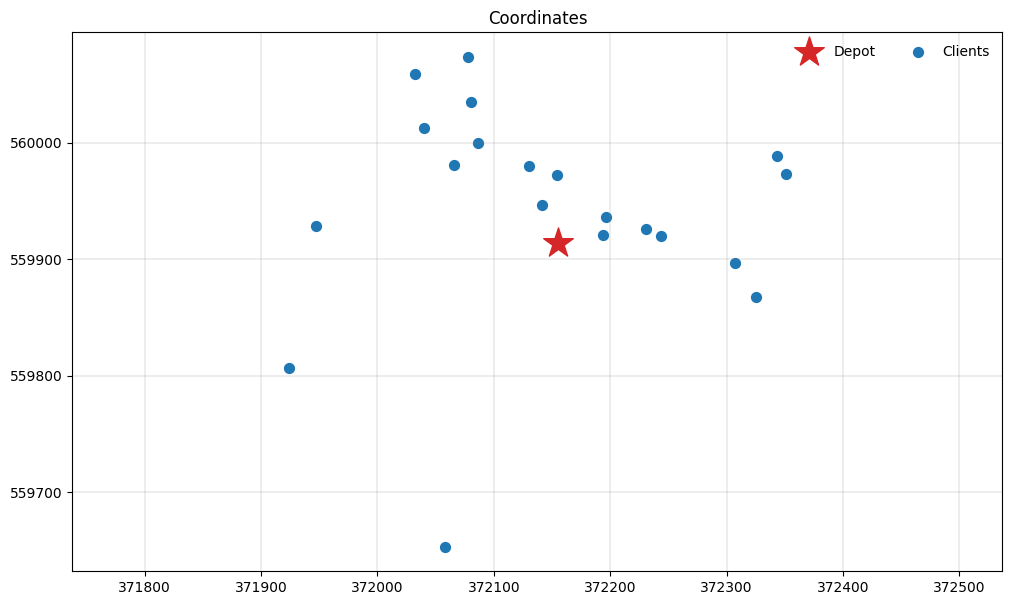

In [57]:
# Point visualizing| Визуализация точек
fig, ax = plt.subplots(figsize=(12, 7))
plotting.plot_coordinates(model.data(), ax=ax)

In [58]:
# Solver launching| Запуск солвера
res_model = model.solve(MaxRuntime(10))

PyVRP v0.10.1

Solving an instance with:
    1 depot
    20 clients
    35 vehicles (2 vehicle types)

                  |       Feasible        |      Infeasible
    Iters    Time |   #      Avg     Best |   #      Avg     Best
H     500      2s |  28    87952    86863 |  36    78954    78031
     1000      4s |  62    88073    86863 |  34    85044    83514
     1500      5s |  30    88395    86863 |  28    84942    83681
     2000      7s |  47    88351    86863 |  39    84474    83175
     2500      8s |  37    88657    86863 |  62    81650    74723
     3000     10s |  43    89102    86863 |  49    81646    79642

Search terminated in 10.00s after 3069 iterations.
Best-found solution has cost 86863.

Solution results
    # routes: 9
   # clients: 20
   objective: 86863
    distance: 27015
    duration: 140
# iterations: 3069
    run-time: 10.00 seconds



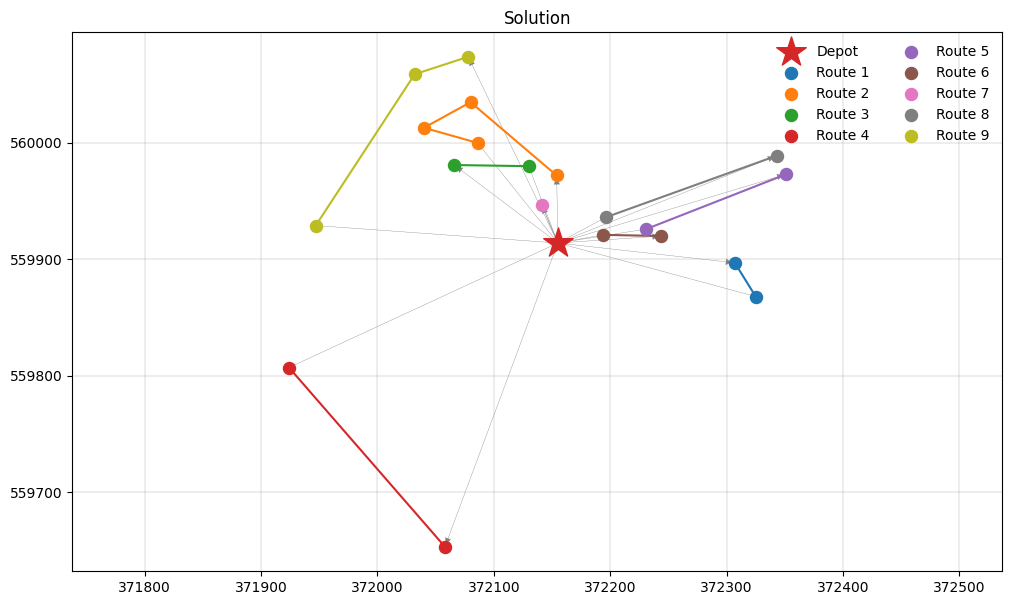

In [59]:
# Rotes of delivering| Маршруты доставки
fig, ax = plt.subplots(figsize=(12, 7))
plotting.plot_solution(res_model.best, model.data(), plot_clients=True, ax=ax)

In [60]:
# Constructing a df with route properties| Собираем датафрейм с атрибутами маршрутов
d = pd.DataFrame({
     'route_idx': [idx - 1 for idx in res_model.best.routes()[i].visits()],
     'route': model_df.iloc[[idx - 1 for idx in res_model.best.routes()[i].visits()]]['address'].values, 
     'sum_distance': res_model.best.routes()[i].distance()/1000,
     'sum_duration': res_model.best.routes()[i].duration(),
     'delivery_amt': res_model.best.routes()[i].delivery(),
     'time_from': res_model.best.routes()[i].start_time()/60,
     'time_to': res_model.best.routes()[i].end_time()/60,
     'vehicle': [{'name': model.vehicle_types[res_model.best.routes()[i].vehicle_type()].name,
     'max_duration': model.vehicle_types[res_model.best.routes()[i].vehicle_type()].max_duration,
     'capacity': model.vehicle_types[res_model.best.routes()[i].vehicle_type()].capacity,
     'start_depot': model.vehicle_types[res_model.best.routes()[i].vehicle_type()].start_depot,
     'fixed_cost': model.vehicle_types[res_model.best.routes()[i].vehicle_type()].fixed_cost}]}  for i in range(len(res_model.best.routes())))

In [61]:
d['time_from'] = d['time_from'].apply(lambda x: '{:02d}:{:02d}'.format(int(x), int((x - int(x))*60)))
d['time_to'] = d['time_to'].apply(lambda x: '{:02d}:{:02d}'.format(int(x), int((x - int(x))*60)))

In [62]:
model_df['dodo_coords'].apply(lambda x: (x.y, x.x)).unique().tolist()

[(55.9914865, 37.215572)]

## Route visualization; delivery point has orange| Визуализация маршрутов; оранжевый - точка доставки

In [85]:
dist_list=[]
routes = d['route_idx'].values
# Getting points iand gether them in routes| Получаем точки и собираем их в маршруты
groups = [model_df['dodo_coords'].apply(lambda x: (x.y, x.x)).unique().tolist()
          +model_df['house_centroid'].apply(lambda x: (x.y, x.x)).values[[i-1 for i in res_model.best.routes()[i]]].tolist()
                                    +model_df['dodo_coords'].apply(lambda x: (x.y, x.x)).unique().tolist() for i in range(len(routes))]

# Colors fom lines and markers| Цвета для маркеров и линий
colors = ['blue', 'red', 'green', 'purple', 'darkred', 'darkblue', 'beige',  'darkgreen', 'white']

# Creating map with centering in on the delivery point| Создаем карту, центрируем ее на первой точке первой группы
m = folium.Map(location=groups[0][0], zoom_start=3)

# Function for adding markers and lines| Функция для добавления маркеров и линий для каждой группы
def add_group_to_map(group, color):
    # Adding points to the map, also adding number of point in route, it will be displayed when the mouse is placed on the marker
    # Добавляем точки на карту, отдельно добавляем номер точки в маршруте, который будет отображаться при наведении
    for j, [lat, lon] in enumerate(group[1:-1]):
        folium.Marker(location=[lat, lon], popup=j+1, tooltip= j+1, icon=folium.Icon(color=color)).add_to(m)
    
    # Adding lines between points| Добавляем линии между точками
        folium.PolyLine(group, color=color, weight=2.5, opacity=1).add_to(m)

    # Calculating lenght of the route| Рассчитываем длину маршрута
    total_distance = 0
    for i in range(len(group) - 1):
        total_distance += great_circle(group[i], group[i + 1]).km
    dist_list.append(total_distance)
    # Adding text with the route distance| Добавляем текст с длиной маршрута на карту
    midpoint = group[len(group) // 2]  # Находим середину маршрута для размещения текста
    folium.Marker(
        location=midpoint,
        icon=folium.DivIcon(html=f'<div style="font-size: 12px; color: black;">{total_distance:.2f} km</div>')
    ).add_to(m)

# Adding routes to the map| Добавляем группы на карту с разными цветами
for i in range(len(routes)):
    color = colors[i % len(colors)]  # Используем цвета циклически
    add_group_to_map(groups[i], color)

popup.add_to(m)

m

In [65]:
d.head()

,route_idx,route,sum_distance,sum_duration,delivery_amt,time_from,time_to,vehicle
0,"[19, 9]","[к622, 6-й микрорайон, Зеленоград, Москва, Цен...",2.472,14,[15],13:00,13:13,"[{'name': 'veh_1', 'max_duration': 30, 'capaci..."
1,"[7, 0, 18, 1]","[к306, Яблоневая аллея, 3-й микрорайон, район ...",3.191,28,[15],12:46,13:13,"[{'name': 'veh_1', 'max_duration': 30, 'capaci..."
2,"[5, 10]","[к410, улица Лётчика Полагушина, 4-й микрорайо...",2.075,14,[10],09:52,10:07,"[{'name': 'veh_2', 'max_duration': 25, 'capaci..."
3,"[4, 15]","[31, Первомайская улица, Малино, Зеленоград, М...",6.735,14,[9],11:00,11:13,"[{'name': 'veh_2', 'max_duration': 25, 'capaci..."
4,"[3, 8]","[к513, Московский проспект, 5-й микрорайон, ра...",2.777,14,[9],13:00,13:13,"[{'name': 'veh_2', 'max_duration': 25, 'capaci..."


In [81]:
groups

[[(55.9914865, 37.215572),
  (55.9897091391733, 37.23070289630154),
  (55.986883502751624, 37.23257569450834),
  (55.9914865, 37.215572)],
 [(55.9914865, 37.215572),
  (55.99723495000001, 37.215405950000005),
  (56.003566477875005, 37.208021777048835),
  (56.00139340000001, 37.204075700000004),
  (56.00006682223786, 37.20861639607488),
  (55.9914865, 37.215572)],
 [(55.9914865, 37.215572),
  (55.99818490809539, 37.20660451579626),
  (55.99804245, 37.2130167),
  (55.9914865, 37.215572)],
 [(55.9914865, 37.215572),
  (55.965378417482356, 37.20585074623551),
  (55.980737900362975, 37.192460263937846),
  (55.9914865, 37.215572)],
 [(55.9914865, 37.215572),
  (55.99735922151439, 37.23510350186527),
  (55.99266780029803, 37.22312266564425),
  (55.9914865, 37.215572)],
 [(55.9914865, 37.215572),
  (55.99204040032125, 37.22443034645781),
  (55.99216174829329, 37.219451360594576),
  (55.9914865, 37.215572)],
 [(55.9914865, 37.215572),
  (55.99479672348086, 37.21412586795895),
  (55.9914865, 37.